In [89]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay, auc 
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [90]:
#Importing some functions to use later
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    """Function to fit model to training data and generate predictions. 
    Another function, performance_metrics_recorder, is called to record the results
    of the predictions to a dataframe for later analysis.

    Args:
        model (instance): An instance of a classifier model.
        X_train (pd.DataFrame): Dataframe containing training data for all columns except target.
        X_test (pd.DataFrame): Dataframe containing testing data for all columns except target.
        y_train (pd.DataFrame): Dataframe containing training data for target column.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.

    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)

    return (model, df, model_confusion)

def performance_metrics_recorder(predictions, y_test, df, model_name):
    """Helper function to record scores for model predictions in a DataFrame.

    Args:
        predictions (pd.DataFrame): Dataframe of predictions generated by classifier.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.
    
    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name,model_accuracy_score,model_precision_score,model_recall_score,model_f1_score,model_roc_auc]

    return(df, model_confusion)

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    """Helper function to visualize feature importance.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    features_list = X.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    """Helper function to visualize feature importance for algorithms that do 
    not support the model.feature_importances_ method.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(), 
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

EDA and Pre-Processing

In [91]:
#Loading the raw CSV data
df = pd.read_csv('C:/Users/VARUN/OneDrive/Desktop/Projects/Classification_of_Mushrooms/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [92]:
# Checking the missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [93]:
df.shape

(8124, 23)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [95]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [96]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


We examined the dataset to identify the column names, their respective data types, and the number of unique values for each feature. All features were found to be of the object data type (string values), each containing multiple distinct categories. Since machine learning models require numerical inputs, these categorical string values must be converted into numeric form. For simplicity and efficiency, we will apply label encoding to transform these features into numerical representations.

In [97]:
# creating a copy of the original dataframe
df2 = df.copy()

In [98]:
# performing Label Encoding on each of the 23 features
for col in df2.columns:
    le = LabelEncoder()
    le.fit(df2[col])
    df2[col] = le.transform(df2[col])
    if col == 'class':
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

{'e': np.int64(0), 'p': np.int64(1)}


The LabelEncoder method has transformed the target classes such that:

'edible' is encoded as 0

'poisonous' is encoded as 1

In [99]:
# check to see counts for each class
counts = df2['class'].value_counts()
print(counts)

class
0    4208
1    3916
Name: count, dtype: int64


In [100]:
# checking ratio of class 'e' vs 'p'
total_counts = 4208 + 3916
print((4208/total_counts)*100) # class 0 = 'e'
print((3916/total_counts)*100) # class 1 = 'p'

51.7971442639094
48.20285573609059


The dataset exhibits a nearly balanced class distribution, with edible and poisonous mushrooms occurring in approximately equal proportions (roughly 50–50). Since the classes are well balanced, there is no need to apply resampling or balancing techniques.

In [101]:
# examining the label-encoded dataframe
df2.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


  
With the dataframe now converted into a numerical format, we can proceed with additional exploratory analysis. As a first step, we will visualize the correlations among the features to better understand their relationships and potential dependencies.

In [102]:
# getting correlation matrix of matrix
corr = df2.corr()
corr.style.background_gradient('coolwarm')

C:\Users\VARUN\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\VARUN\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [103]:
# checking the veil-type column, which has nan
df2['veil-type'].unique()

array([0])

The presence of NaN values in the correlation matrix for the veil-type column arises because this feature was encoded entirely as 0. Upon reviewing the original dataset, we note that veil-type contains only a single category, 'p', which has been mapped to 0 during label encoding. Since the feature lacks variability, it does not contribute meaningful information to correlation analysis. Whether this becomes a limitation in later stages of modeling remains uncertain and will depend on how the feature interacts with the overall pipeline.

In [104]:
# standardizing the data
df3 = df2.copy()
scaler = StandardScaler()
df3 = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [105]:
# getting correlation matrix of standardized matrix
corr = df3.corr()
corr.style.background_gradient('coolwarm')

C:\Users\VARUN\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\VARUN\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


Applying classification algorithms

In [107]:
# splitting dataset
X = df2.drop(['class'],axis=1)
Y = df2['class']

In [108]:
# creating train/test split using 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [109]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1","roc_auc"]
performance_metrics = pd.DataFrame(columns=column_names)

In [110]:
# Naive Bayes
nb = GaussianNB()
nb, performance_metrics, nb_confusion = model_predictions(nb, X_train, X_test, y_train, y_test, performance_metrics, "Naive Bayes")

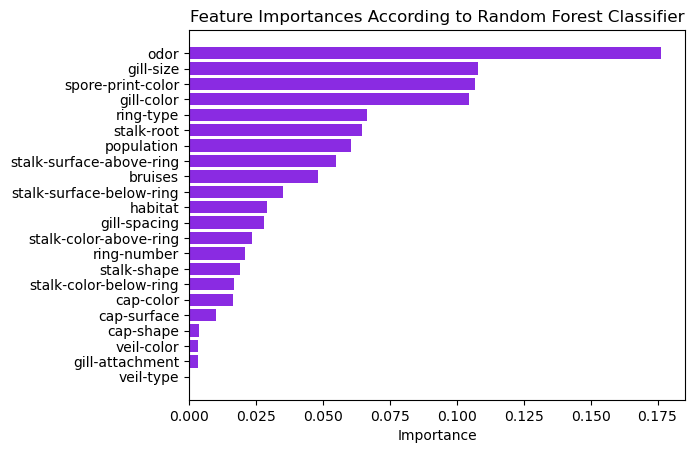

In [111]:
# Random Forest
label = "Random Forest"
rf = RandomForestClassifier(random_state=42)
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")

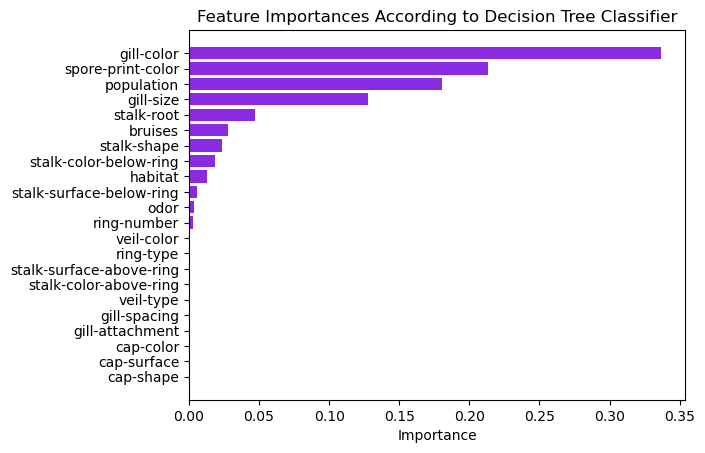

In [112]:
# Decision Tree
label = "Decision Tree"
dt = tree.DecisionTreeClassifier()
dt, performance_metrics, dt_confusion = model_predictions(dt, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, dt, label, color="blueviolet")

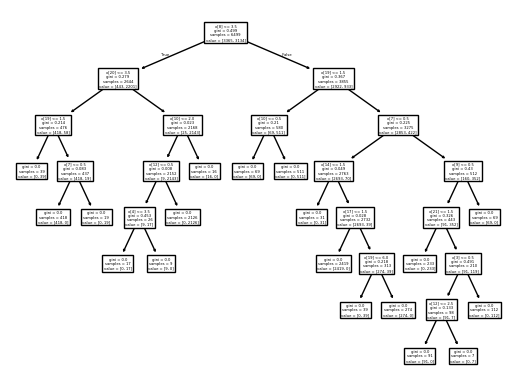

In [113]:
# also plotting decision tree
tree.plot_tree(dt);

C:\Users\VARUN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


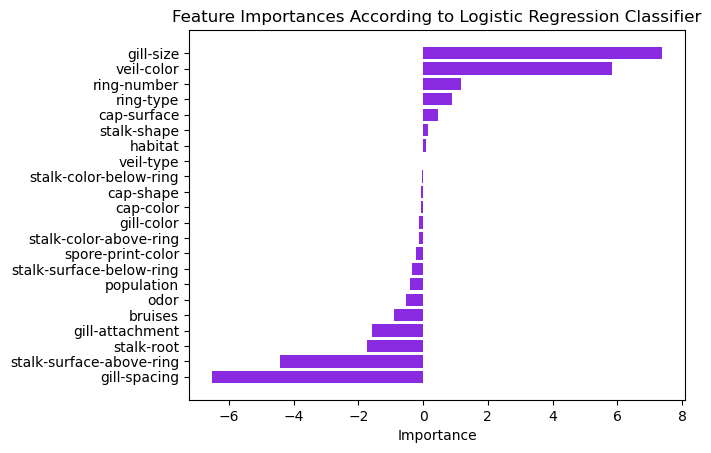

In [114]:
# Logistic Regression
label = "Logistic Regression"
lr = LogisticRegression()
lr, performance_metrics, lr_confusion = model_predictions(lr, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, lr, label, color="blueviolet");

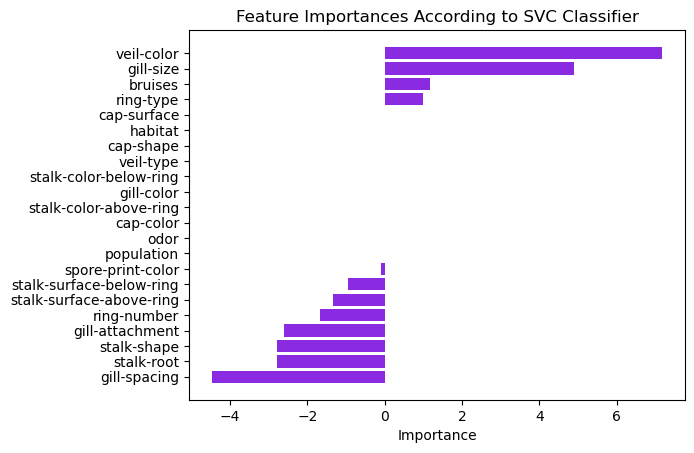

In [115]:
# Support Vector Classifier
label = "SVC"
svc = SVC(kernel='linear')
svc, performance_metrics, svc_confusion = model_predictions(svc, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, svc, label, color="blueviolet")

In [116]:
# K Neighbours
label = "KNN"
knn = KNeighborsClassifier()
knn, performance_metrics, knn_confusion = model_predictions(knn, X_train, X_test, y_train, y_test, performance_metrics, label)
# feature importance function not defined for KNN algorithm

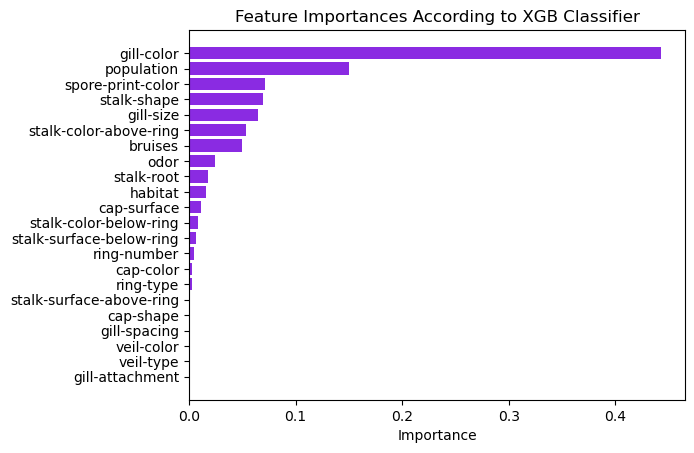

In [117]:
# XGBoost
label = "XGB"
xgboost = xgb.XGBClassifier()
xgboost, performance_metrics, xgb_confusion = model_predictions(xgboost, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, xgboost, label, color="blueviolet")

In [118]:
# examining metrics dataframe
performance_metrics

,method,accuracy,precision,recall,f1,roc_auc
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129
1,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
6,XGB,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\VARUN\AppData\Local\Temp\ipykernel_4900\4285751722.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


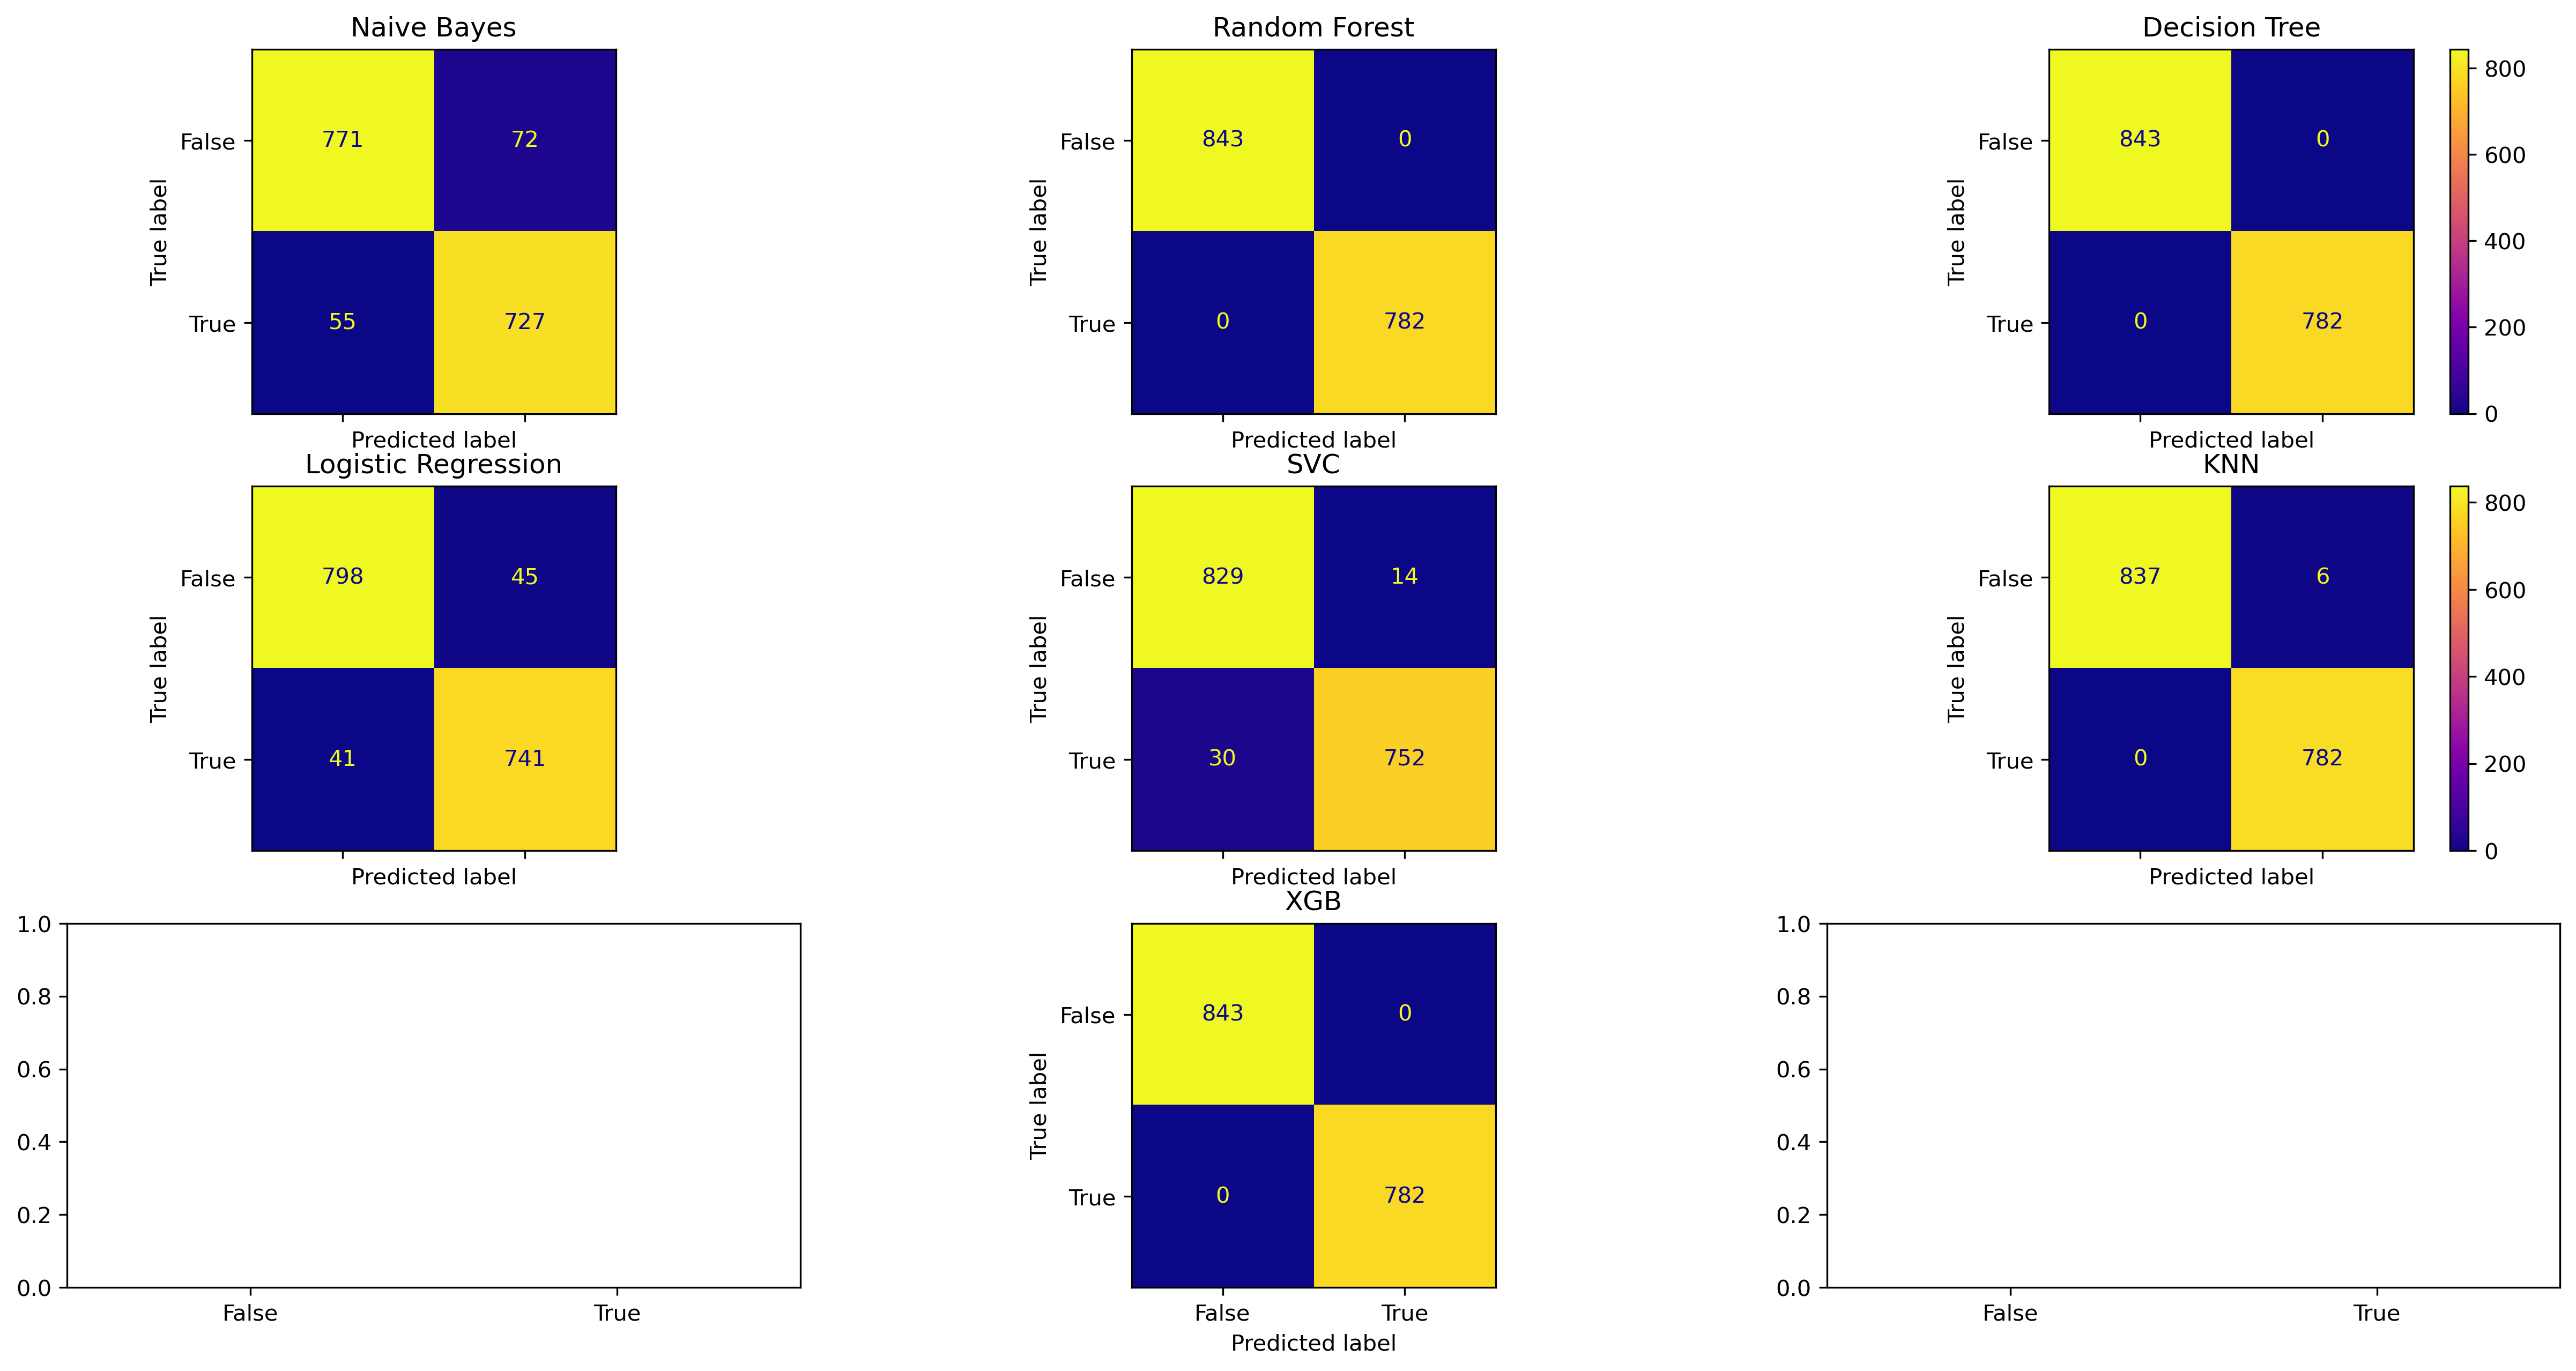

In [119]:
# comparing confusion matrices for this stage of analysis
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))

fig, ax = plt.subplots(3,3,sharex=True, sharey=False, figsize=(20, 10), dpi=300)

# first row
ax[0, 0].set_title(x_labels[0])
ax[0, 1].set_title(x_labels[1])
ax[0, 2].set_title(x_labels[2])
# second row
ax[1, 0].set_title(x_labels[3])
ax[1, 1].set_title(x_labels[4])
ax[1, 2].set_title(x_labels[5])
# third row
ax[2, 1].set_title(x_labels[6])

# first row
ConfusionMatrixDisplay(nb_confusion,display_labels=[False,True]).plot(ax=ax[0, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_confusion,display_labels=[False,True]).plot(ax=ax[0, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(dt_confusion,display_labels=[False,True]).plot(ax=ax[0, 2],cmap='plasma',colorbar=True)
# second row
ConfusionMatrixDisplay(lr_confusion,display_labels=[False,True]).plot(ax=ax[1, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(svc_confusion,display_labels=[False,True]).plot(ax=ax[1, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(knn_confusion,display_labels=[False,True]).plot(ax=ax[1, 2],cmap='plasma',colorbar=True)
# third row
ConfusionMatrixDisplay(xgb_confusion,display_labels=[False,True]).plot(ax=ax[2, 1],cmap='plasma',colorbar=False)
fig.show()

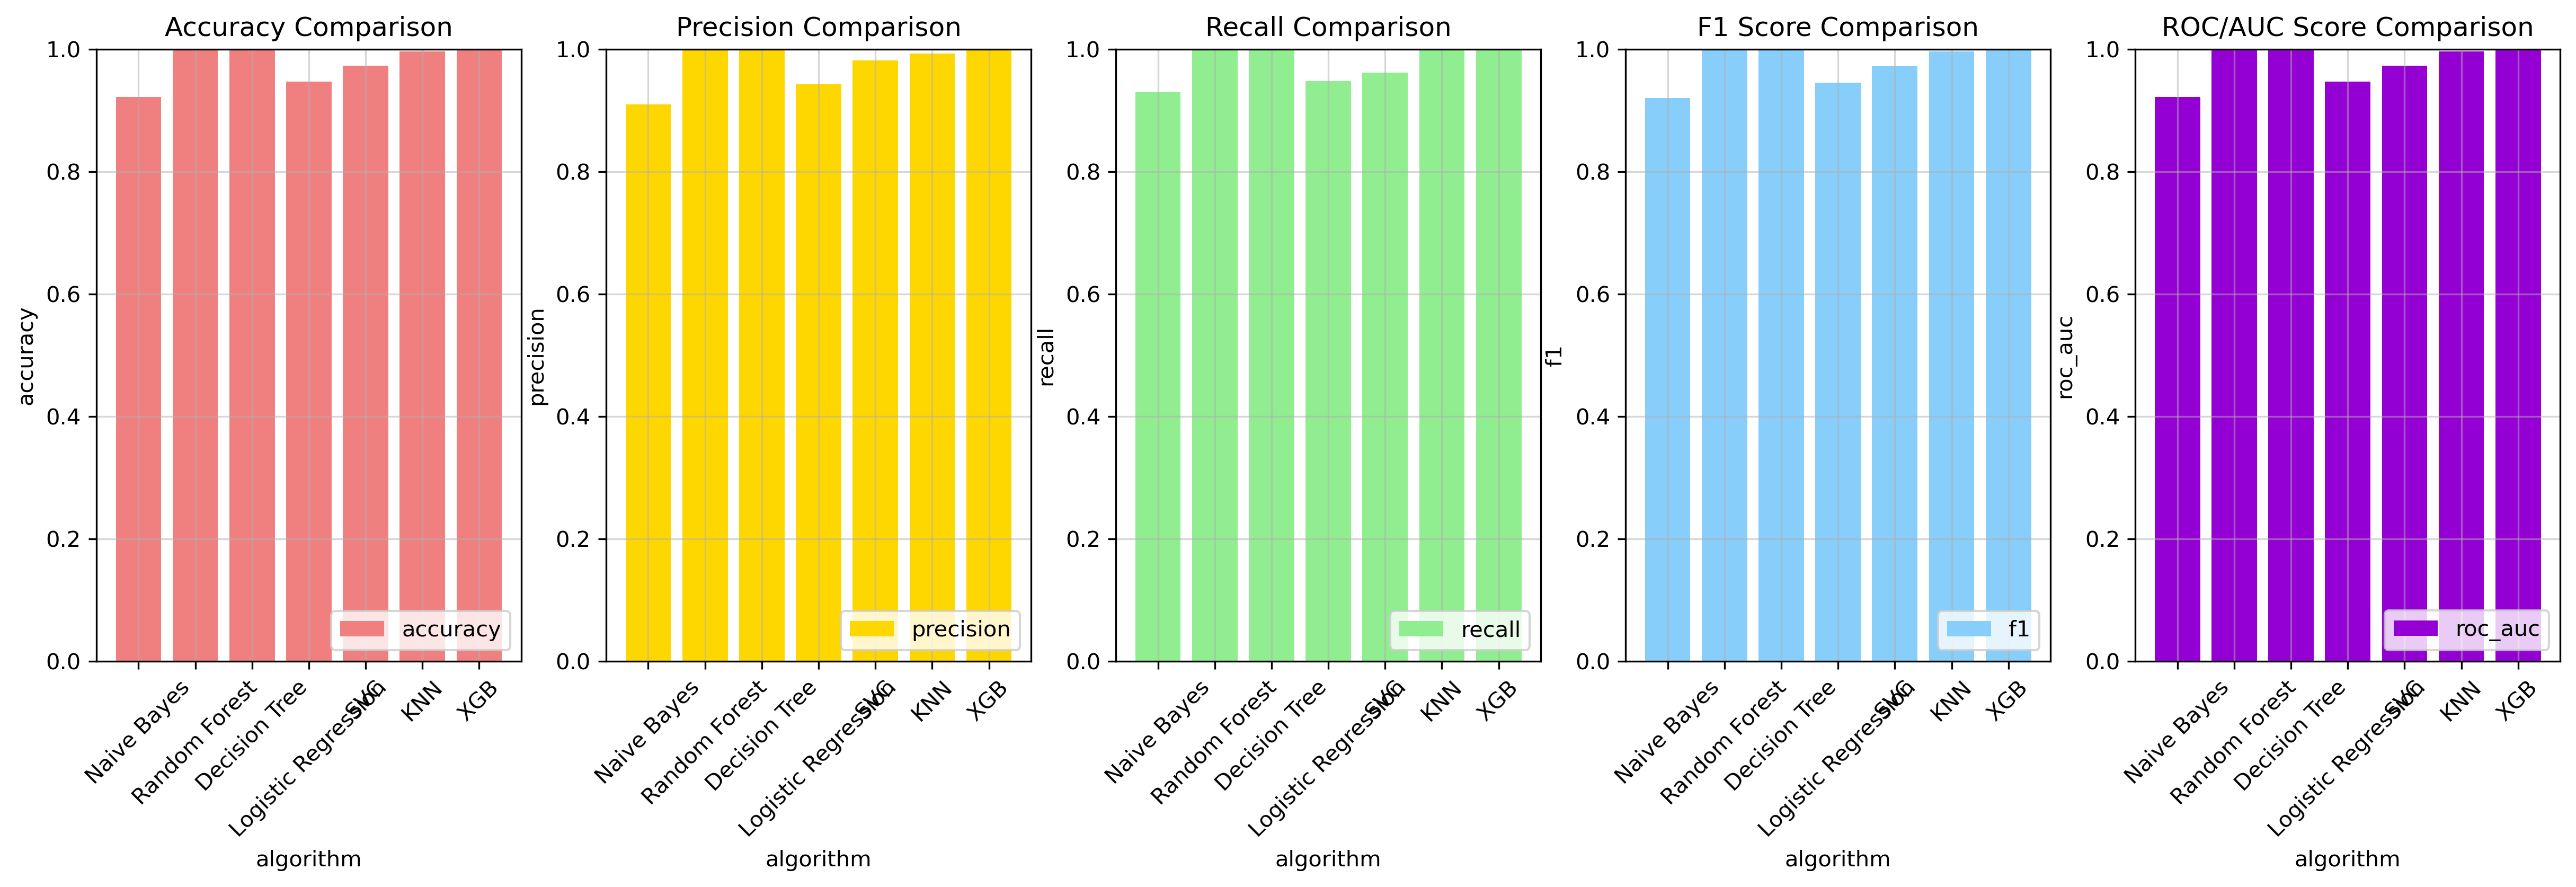

In [121]:
# comparing all metrics
fig, ax = plt.subplots(1, 5, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))
width = 0.3

#row=0, col=0
ax[0].bar(indices,performance_metrics['accuracy'],color="lightcoral",alpha=1,label="accuracy") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,performance_metrics['precision'],color="gold",alpha=1,label="precision") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,performance_metrics['recall'],color="lightgreen",alpha=1,label="recall") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,performance_metrics['f1'],color="lightskyblue",alpha=1,label="f1") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

#row=0, col=4
ax[4].bar(indices,performance_metrics['roc_auc'],color="darkviolet",alpha=1,label="roc_auc") 
ax[4].grid(True,alpha=0.5)
ax[4].set_ylim(0,1)
ax[4].set_xlabel("algorithm")
ax[4].set_ylabel("roc_auc")
ax[4].set_title("ROC/AUC Score Comparison")
ax[4].legend(loc='lower right')
ax[4].set_xticks(indices, x_labels, rotation=45)

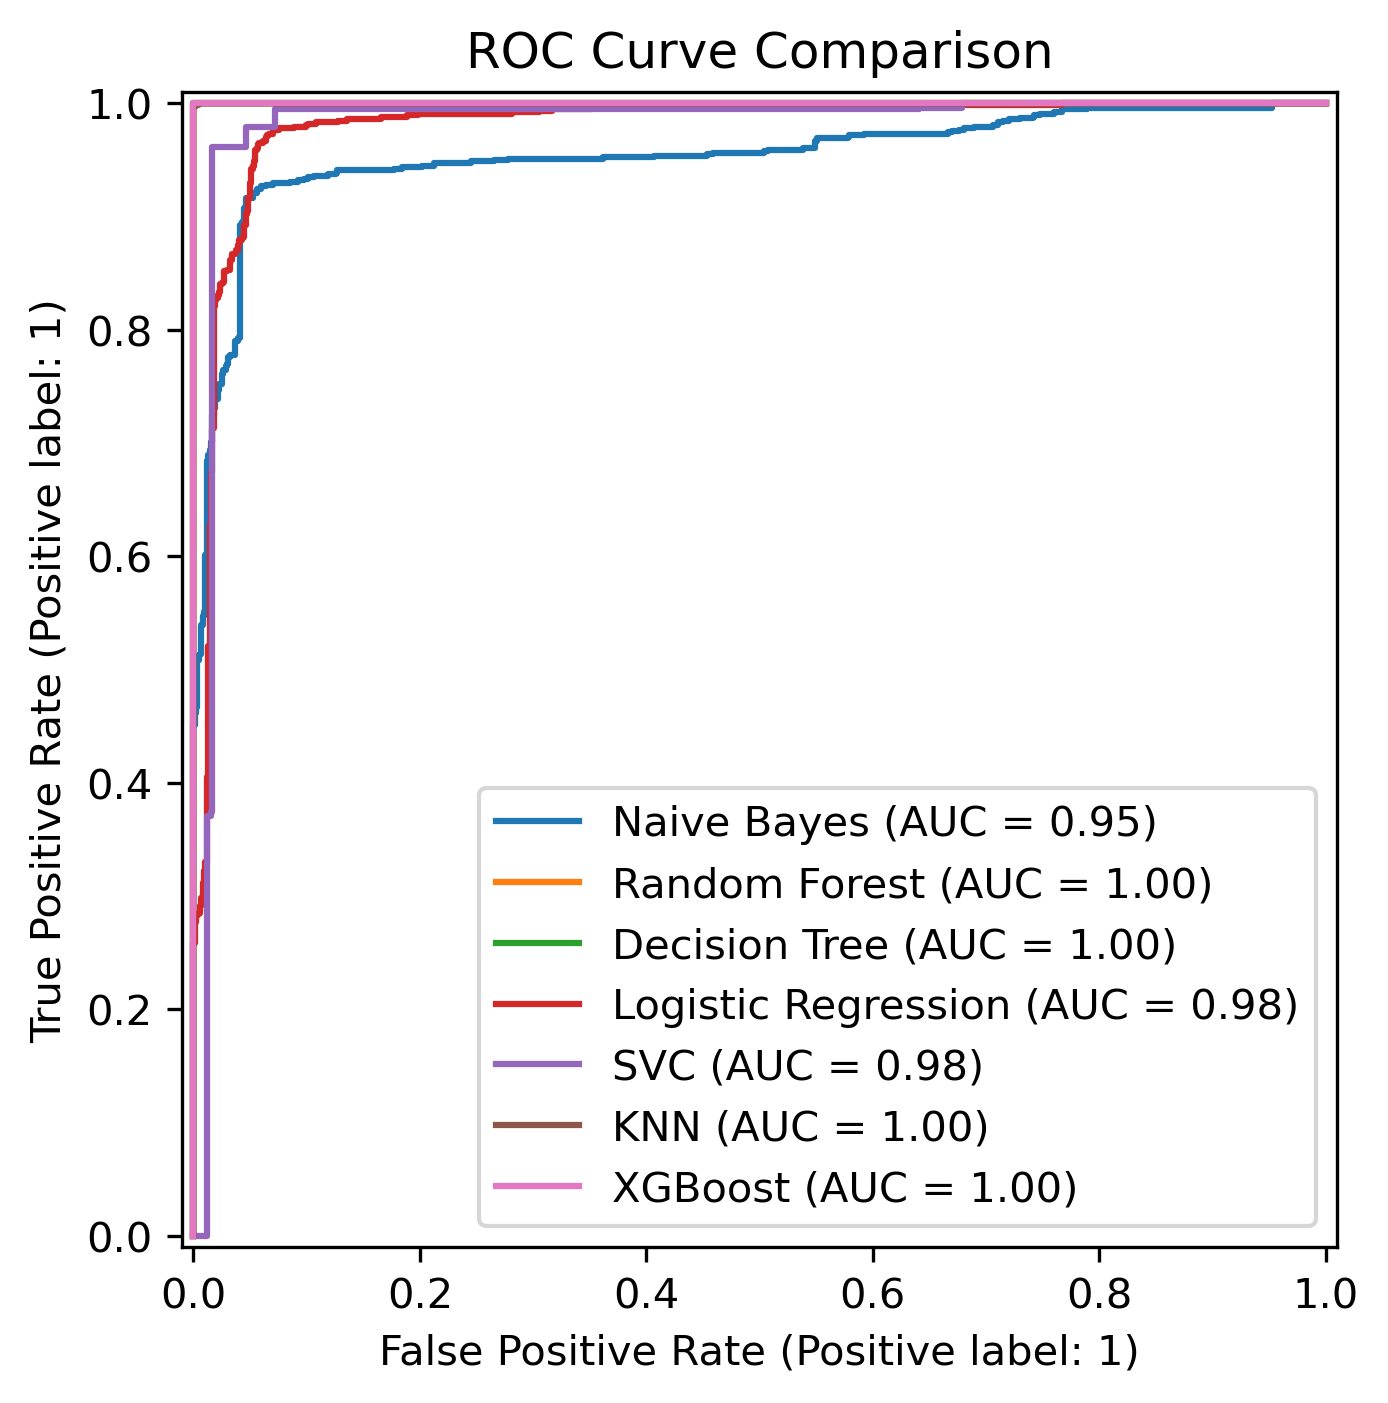

In [124]:
# plotting ROC curves with AUC scores
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Use from_estimator method instead of direct constructor
RocCurveDisplay.from_estimator(nb, X_test, y_test, ax=ax, name='Naive Bayes')
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, name='Random Forest')
RocCurveDisplay.from_estimator(dt, X_test, y_test, ax=ax, name='Decision Tree')
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax, name='SVC')
RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax, name='KNN')
RocCurveDisplay.from_estimator(xgboost, X_test, y_test, ax=ax, name='XGBoost')

plt.title("ROC Curve Comparison")
plt.show()

The goal of this project is to identify the most effective algorithm for classifying mushrooms as either edible or poisonous. We experimented with seven different algorithms and evaluated their performance. To determine the best-performing model, we now turn to evaluation metrics commonly used in classification tasks.

ined in terms of positives and negatives, as represented in a confusion matrix.

In our case, the positive class (1) corresponds to poisonous mushrooms.

The negative class (0) corresponds to edible mushrooms.

This framing means our models are primarily tasked with identifying poisonous mushrooms (the hypothesis), rather than edible ones.

True Positives (TP): Instances correctly classified as poisonous (actual = 'p', predicted = 'p').

False Positives (FP): Instances incorrectly classified as poisonous (actual = 'e', predicted = 'p').

False Negatives (FN): Instances incorrectly classified as edible (actual = 'p', predicted = 'e').

True Negatives (TN): Instances correctly classified as edible (actual = 'e', predicted = 'e').

Accuracy  
Accuracy measures the proportion of correctly classified instances across all classes.

It is particularly effective when the dataset is balanced (as in our case) and when all classes are equally important.

Precision  
Precision quantifies how often predictions of the positive class (poisonous mushrooms) are correct.

In other words, it measures the proportion of True Positives (TPs) among all predicted positives.

For this project, precision is critical because misclassifying a poisonous mushroom as edible could have serious consequences.

Recall  
Recall measures how effectively the model identifies actual positive cases.

It calculates the proportion of True Positives correctly detected out of all actual positives.

In this context, recall ensures that poisonous mushrooms are not overlooked.

Similarly, recall for the negative class (edible mushrooms) reflects how well the model avoids false alarms

F1 Score  
The F1 score is the harmonic mean of precision and recall, balancing both metrics.

It provides a single measure of performance that accounts for both correctly identifying poisonous mushrooms and correctly classifying edible ones.

This makes it a robust metric when both precision and recall are important.

ROC/AUC Score

The ROC (Receiver Operating Characteristic) curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR).

The AUC (Area Under the Curve) quantifies the overall ability of the model to distinguish between classes.

A higher AUC indicates stronger predictive performance across both edible and poisonous mushrooms.

After reviewing all evaluation metrics, we have selected precision as our primary metric. This choice reflects the critical need to minimize the risk of misclassifying poisonous mushrooms as edible, since ensuring that most poisonous samples are correctly identified is essential for safety. Before proceeding with model evaluation, it is important to note that several algorithms reported perfect scores (100%) across all metrics. Such results strongly suggest overfitting, meaning these models memorized patterns from the training data and applied them directly to the test set without generalizing effectively. To avoid misleading conclusions, we will exclude these overfitted models—Random Forest, Decision Tree, K-Nearest Neighbors, and XGBoost—from the final evaluation.

With this background established, we can now move forward to assess the remaining models. The next step is to examine the performance metrics table, filtered to remove the overfitted algorithms, with accuracy included as a reference measure.


In [125]:
performance_metrics[performance_metrics['accuracy']!=1].sort_values('precision', ascending=False)

,method,accuracy,precision,recall,f1,roc_auc
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129


Based on our primary metric, precision, the K-Nearest Neighbors (KNN) model achieved the highest performance, followed by the Support Vector Classifier (SVC, linear kernel), then Logistic Regression, with Naive Bayes performing the weakest.

KNN: 99% precision

SVC (linear): 98% precision

Logistic Regression: 94% precision

Naive Bayes: 90% precision

This indicates that the KNN model correctly identified 99% of poisonous mushrooms as poisonous.

Other evaluation metrics show a similar ranking, with KNN consistently outperforming the alternatives. Notably, KNN achieved 100% recall, meaning it correctly classified all edible mushrooms as edible—a particularly strong result.

From this comparative analysis, we conclude that either the K-Nearest Neighbors (KNN) algorithm or the Support Vector Classifier (SVC) is most suitable for classifying mushrooms in this dataset.

According to the SVC model, the most influential features in determining whether a mushroom is poisonous include:

Veil color

Gill size

Bruises

Ring type

Conversely, features such as gill spacing, stalk root, stalk shape, gill attachment, and ring number contributed minimally to classification outcomes.

If such an algorithm were deployed in a real-world scenario—for example, assisting mushroom identification in the forest—the KNN or SVC models would be the preferred choice. In practice, particular attention should be paid to veil color, gill size, bruises, and ring type, as these features strongly corroborate the algorithm’s predictions regarding mushroom toxicity.